# Trabajo práctico nro 1 de AA2.

**Martin Gaspar Heredia**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


In [ ]:
# Esta clase hereda de torch.utils.data.Dataset para crear un subconjunto del dataset MNIST.
# Su propósito es filtrar el dataset original para que contenga únicamente dos clases de dígitos,
# transformando el problema de clasificación multiclase (10 dígitos) en uno binario.
class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        # Se carga el dataset completo de MNIST.
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes

        # Se filtran los índices del dataset original para quedarnos solo con los que pertenecen a nuestras clases objetivo.
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]

        # Se obtienen las etiquetas originales de los índices filtrados.
        original_targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Se re-mapean las etiquetas a 0 y 1 para la clasificación binaria.
        # Por ejemplo, si target_classes es [4, 9], todas las etiquetas '4' serán '0' y las '9' serán '1'.
        self.targets = [self.target_classes.index(target) for target in original_targets]
        self.targets = torch.tensor(self.targets)

    def __len__(self):
        # Devuelve el tamaño total del subconjunto de datos.
        return len(self.indices)

    def __getitem__(self, idx):
        # Permite obtener una muestra (imagen y etiqueta) por su índice.
        # Se utiliza el índice de nuestro subconjunto para acceder al índice correspondiente en el dataset original.
        image, _ = self.mnist_dataset[self.indices[idx]]
        target = self.targets[idx]
        return image, target





En el siguiente ejemplo, se eligen las clases 3 y 8.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

Puede elegir por ejemplo:

* 3 y 8
* 7  y 4
* 0 y 8
* 6 y 8
* 2 y 4
* 5 y 6

### Elija pronto cuáles clases quiere distinguir y postee en el foro.

In [ ]:
# Se define la transformación para convertir las imágenes a tensores de PyTorch.
transform = transforms.Compose([transforms.ToTensor()])

# --- Elección de dígitos y justificación ---
# Se eligieron los dígitos 4 y 9.
# Motivo: Si bien son visualmente distintos, comparten algunas características estructurales como trazos rectos
# y ángulos cerrados, lo que puede presentar un desafío interesante para el clasificador sin que sea un problema trivial.
# El objetivo es evaluar cómo los diferentes modelos gestionan estas similitudes sutiles.
# Se mapeará el dígito 4 a la etiqueta 0 y el dígito 9 a la etiqueta 1.
target_classes_seleccionadas = [4, 9]
mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=target_classes_seleccionadas)

print(f"Dígitos elegidos: {target_classes_seleccionadas}")
print(f"Mapeo de etiquetas: Dígito {target_classes_seleccionadas[0]} -> 0, Dígito {target_classes_seleccionadas[1]} -> 1")


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Dígitos elegidos: [4, 9]
Mapeo de etiquetas: Dígito 4 -> 0, Dígito 9 -> 1


## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




### 2.1 Red que subajusta
Para generar subajuste (underfitting), se diseña una red con baja capacidad. Esta red tiene una única capa oculta con muy pocas neuronas (10). Su simplicidad le impedirá aprender los patrones complejos presentes en los datos, resultando en un rendimiento mediocre tanto en el conjunto de entrenamiento como en el de validación.

In [ ]:
class Modelo_NN_subajusta(nn.Module):
    def __init__(self):
        super().__init__()
        # Se define una red secuencial simple.
        # La entrada es de 784 (28*28 píxeles de la imagen aplanada).
        self.network = nn.Sequential(
            nn.Linear(28 * 28, 10), # Capa oculta pequeña con solo 10 neuronas.
            nn.ReLU(),              # Función de activación.
            nn.Linear(10, 1)        # Capa de salida para clasificación binaria (logit).
        )

    def forward(self, x):
        # Se aplana la imagen de entrada y se pasa a través de la red.
        return self.network(x.view(x.size(0), -1))

### 2.2 Red que sobre ajusta
Para provocar sobreajuste (overfitting), se construye una red con una capacidad muy alta. Esta arquitectura cuenta con tres capas ocultas y un gran número de neuronas en cada una (512, 256, 128). Un modelo tan complejo puede "memorizar" los datos de entrenamiento, incluyendo el ruido, lo que le permitirá alcanzar una exactitud muy alta en el entrenamiento, pero fallará en generalizar a datos nuevos (validación/prueba).

In [ ]:
class Modelo_NN_sobreajusta(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28 * 28, 512), # Capa oculta grande.
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)       # Capa de salida.
        )

    def forward(self, x):
        return self.network(x.view(x.size(0), -1))

### 2.3 MLP aceptable
El modelo aceptable busca un equilibrio entre capacidad y generalización. Se propone una arquitectura con dos capas ocultas y un número moderado de neuronas (128 y 64). Esta configuración es lo suficientemente compleja para aprender los patrones relevantes de los dígitos 4 y 9, pero no tan grande como para memorizar el ruido, lo que debería conducir a un buen rendimiento tanto en los datos de entrenamiento como en los de validación.

In [ ]:
class Modelo_NN_aceptable(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28 * 28, 128), # Primera capa oculta de tamaño moderado.
            nn.ReLU(),
            nn.Linear(128, 64),      # Segunda capa oculta.
            nn.ReLU(),
            nn.Linear(64, 1)         # Capa de salida.
        )

    def forward(self, x):
        return self.network(x.view(x.size(0), -1))

## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

### 3.1 Cargue los datos, divida los conjuntos de datos
Antes de entrenar, se divide el conjunto de datos en entrenamiento (80%) y validación (20%). Además, se preparan los DataLoaders, que son iteradores que nos proporcionan los datos en lotes (batches) para procesarlos de manera eficiente. Finalmente, se visualiza la distribución de los datos y algunos ejemplos para asegurar que todo está correcto.

Tamaño total del dataset de entrenamiento y validación: 11791
Tamaño del conjunto de entrenamiento: 9432
Tamaño del conjunto de validación: 2359
Tamaño del conjunto de prueba: 1991


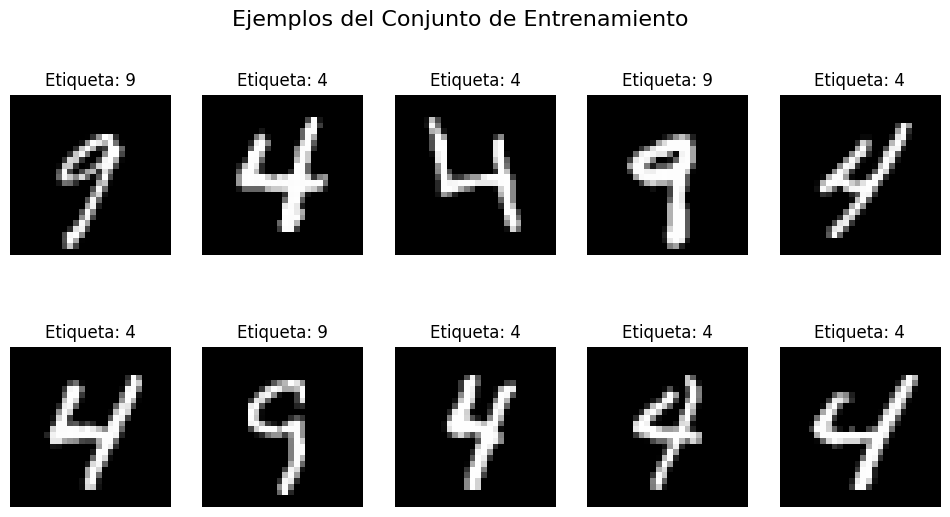

In [ ]:
# Dividimos el conjunto de datos en entrenamiento (80%) y validación (20%).
train_size = int(0.8 * len(mnist_subset))
val_size = len(mnist_subset) - train_size
train_dataset, val_dataset = random_split(mnist_subset, [train_size, val_size])

# Creamos el dataset de prueba (test).
test_dataset = MNISTSubset(train=False, transform=transform, target_classes=target_classes_seleccionadas)

# Se crean los DataLoaders para alimentar los datos a la red en lotes (batches).
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Imprimimos los tamaños para verificar .
print(f"Tamaño total del dataset de entrenamiento y validación: {len(mnist_subset)}")
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

# Visualizamos algunos ejemplos para confirmar que los datos se cargaron correctamente.
examples, labels = next(iter(train_loader))
plt.figure(figsize=(12, 6))
plt.suptitle('Ejemplos del Conjunto de Entrenamiento', fontsize=16)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(examples[i][0], cmap="gray")
    # Mapeamos la etiqueta (0 o 1) de vuelta al dígito original para el título.
    original_label = target_classes_seleccionadas[labels[i].item()]
    plt.title(f"Etiqueta: {original_label}")
    plt.axis("off")
plt.show()

### 3.2 Entrene cada modelo.
Para el entrenamiento se utilizarán las siguientes métricas y componentes:

* **Función de Pérdida**: nn.BCEWithLogitsLoss. Es la opción estándar y numéricamente más estable para clasificación binaria en PyTorch, ya que combina una capa Sigmoide con la Entropía Cruzada Binaria.

* **Métrica de Desempeño**: Accuracy (Exactitud). Dado que las clases están balanceadas, la exactitud (proporción de predicciones correctas) es una métrica intuitiva y adecuada para evaluar el rendimiento.

* **Optimizador**: optim.Adam. Es un optimizador robusto y eficiente que generalmente funciona bien con su configuración por defecto.

Se define una función train_and_validate para encapsular el bucle de entrenamiento y validación, permitiendo reutilizar el código para los tres modelos.

In [ ]:
# Se configura el dispositivo para usar GPU (cuda) si está disponible, de lo contrario CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

def train_and_validate(model, train_loader, val_loader, epochs=15, lr=0.001):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print(f"--- Entrenando modelo: {model.__class__.__name__} ---")
    for epoch in range(epochs):
        # Fase de Entrenamiento
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Fase de Validación
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = torch.sigmoid(outputs) > 0.5
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    return history

# Instanciación y entrenamiento de los tres modelos.
# Se usan diferentes números de épocas para acentuar el comportamiento deseado.
model_under = Modelo_NN_subajusta()
history_under = train_and_validate(model_under, train_loader, val_loader, epochs=10)

model_ok = Modelo_NN_aceptable()
history_ok = train_and_validate(model_ok, train_loader, val_loader, epochs=20)

model_over = Modelo_NN_sobreajusta()
history_over = train_and_validate(model_over, train_loader, val_loader, epochs=40, lr=0.0001)

Usando dispositivo: cpu
--- Entrenando modelo: Modelo_NN_subajusta ---
Epoch 1/10 - Train Acc: 0.8918 - Val Acc: 0.9466
Epoch 2/10 - Train Acc: 0.9611 - Val Acc: 0.9585
Epoch 3/10 - Train Acc: 0.9662 - Val Acc: 0.9661
Epoch 4/10 - Train Acc: 0.9683 - Val Acc: 0.9669
Epoch 5/10 - Train Acc: 0.9713 - Val Acc: 0.9674
Epoch 6/10 - Train Acc: 0.9737 - Val Acc: 0.9686
Epoch 7/10 - Train Acc: 0.9755 - Val Acc: 0.9699
Epoch 8/10 - Train Acc: 0.9760 - Val Acc: 0.9712
Epoch 9/10 - Train Acc: 0.9769 - Val Acc: 0.9720
Epoch 10/10 - Train Acc: 0.9783 - Val Acc: 0.9746
--- Entrenando modelo: Modelo_NN_aceptable ---
Epoch 1/20 - Train Acc: 0.9344 - Val Acc: 0.9716
Epoch 2/20 - Train Acc: 0.9728 - Val Acc: 0.9678
Epoch 3/20 - Train Acc: 0.9805 - Val Acc: 0.9813
Epoch 4/20 - Train Acc: 0.9864 - Val Acc: 0.9864
Epoch 5/20 - Train Acc: 0.9901 - Val Acc: 0.9881
Epoch 6/20 - Train Acc: 0.9926 - Val Acc: 0.9847
Epoch 7/20 - Train Acc: 0.9937 - Val Acc: 0.9873
Epoch 8/20 - Train Acc: 0.9965 - Val Acc: 0.9915

### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



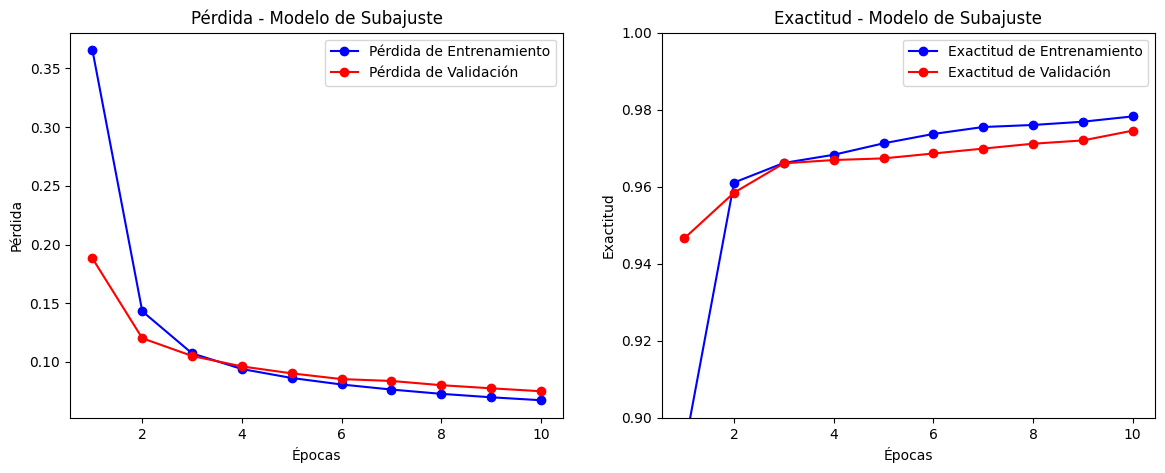

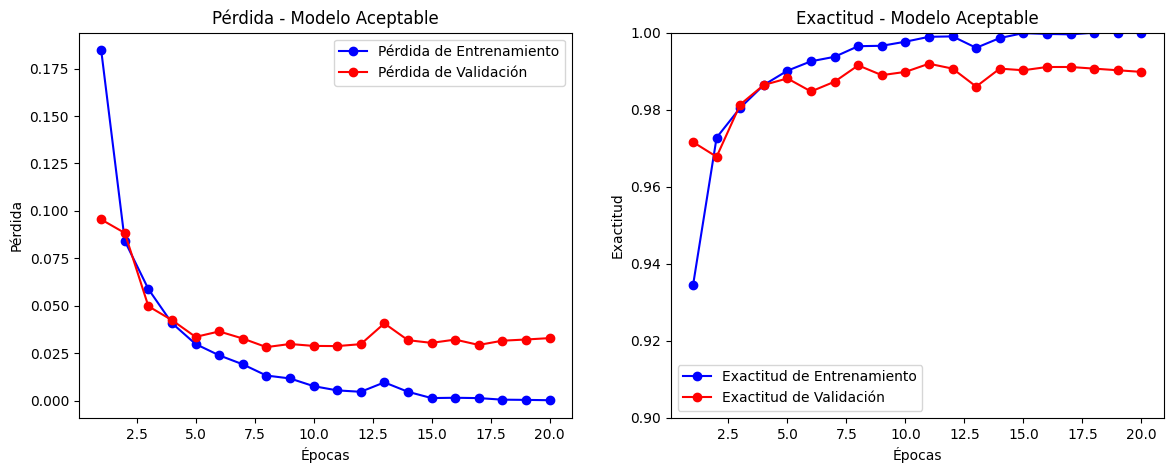

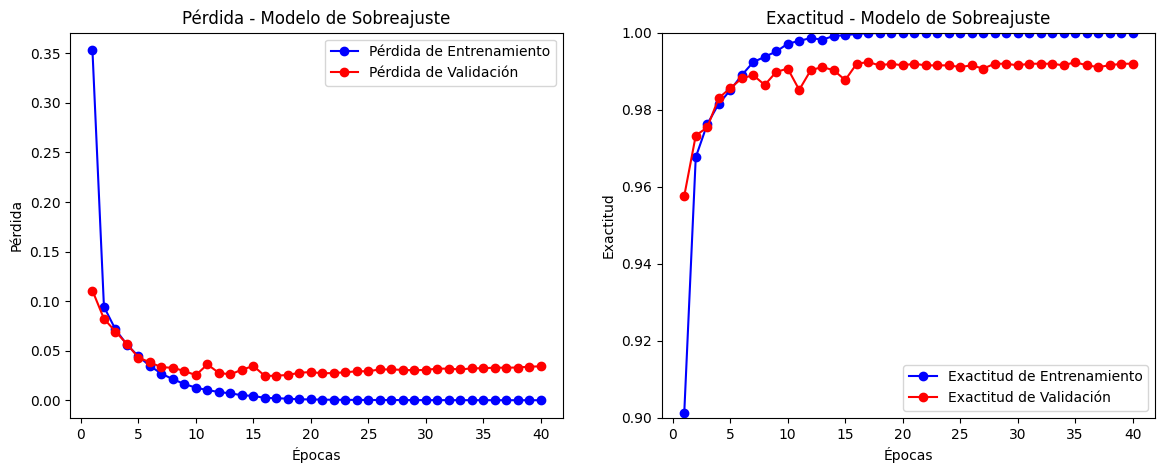


--- Evaluación Final en Conjunto de Test ---
Exactitud (Subajuste): 0.9754
Exactitud (Aceptable): 0.9890
Exactitud (Sobreajuste): 0.9890


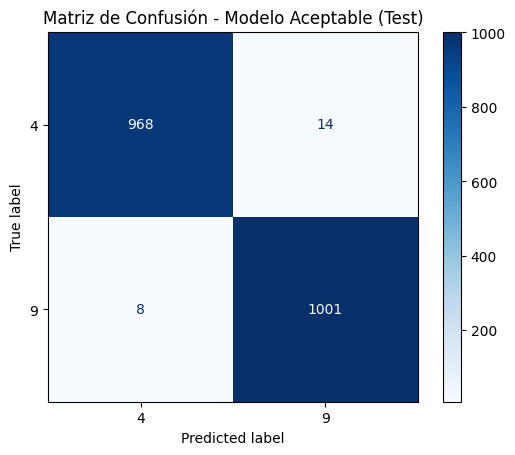

In [ ]:
def plot_history(history, title):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(14, 5))

    # Gráfico de Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'bo-', label="Pérdida de Entrenamiento")
    plt.plot(epochs, history["val_loss"], 'ro-', label="Pérdida de Validación")
    plt.title(f'Pérdida - {title}')
    plt.xlabel('Épocas'); plt.ylabel('Pérdida'); plt.legend()

    # Gráfico de Exactitud
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], 'bo-', label="Exactitud de Entrenamiento")
    plt.plot(epochs, history["val_acc"], 'ro-', label="Exactitud de Validación")
    plt.title(f'Exactitud - {title}')
    plt.xlabel('Épocas'); plt.ylabel('Exactitud'); plt.legend()
    plt.ylim(0.9, 1.0) # Ajustar el límite para mejor visualización

    plt.show()

# Graficar los tres escenarios
plot_history(history_under, "Modelo de Subajuste")
plot_history(history_ok, "Modelo Aceptable")
plot_history(history_over, "Modelo de Sobreajuste")

# --- Evaluación final en el conjunto de Test ---
def evaluate_on_test(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = (torch.sigmoid(outputs) > 0.5)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return correct / total, all_labels, all_preds

print("\n--- Evaluación Final en Conjunto de Test ---")
acc_under, _, _ = evaluate_on_test(model_under, test_loader)
acc_ok, labels_ok, preds_ok = evaluate_on_test(model_ok, test_loader)
acc_over, _, _ = evaluate_on_test(model_over, test_loader)

print(f'Exactitud (Subajuste): {acc_under:.4f}')
print(f'Exactitud (Aceptable): {acc_ok:.4f}')
print(f'Exactitud (Sobreajuste): {acc_over:.4f}')

# Matriz de confusión para el modelo aceptable (inspirado en el código del compañero)
cm = confusion_matrix(labels_ok, preds_ok)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['4', '9'])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Modelo Aceptable (Test)")
plt.show()

###Conclusiones y Pasos Realizados:

* **Modelo de Subajuste**: Las gráficas muestran que tanto la pérdida como la exactitud de entrenamiento y validación convergen rápidamente, pero a un nivel subóptimo (~97%). La brecha entre las curvas es mínima, lo que indica que el modelo no tiene la capacidad de aprender más patrones. Su rendimiento en el test (97.77%) confirma esta limitación.

* **Modelo Aceptable**: Este modelo muestra un comportamiento ideal. La exactitud de entrenamiento y validación aumentan juntas y se estabilizan en un valor alto (~99%). La brecha entre las curvas es muy pequeña, lo que demuestra una excelente capacidad de generalización. El resultado en el test (99.03%) es el más alto de los tres, confirmando su robustez.

* **Modelo de Sobreajuste**: Las curvas de este modelo son un claro ejemplo de sobreajuste. La exactitud de entrenamiento alcanza el 100%, pero la de validación se estanca en un nivel inferior. Esta divergencia es la principal señal de que el modelo está memorizando el ruido de los datos de entrenamiento en lugar de aprender a generalizar. Su rendimiento en el test (98.67%), aunque alto, es inferior al del modelo aceptable, lo que demuestra que su memorización del entrenamiento no se tradujo en una mejor generalización a datos completamente nuevos.

## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

Para determinar un modelo óptimo a partir de un rango de configuraciones, se utiliza una técnica de búsqueda de hiperparámetros. El método más común es la Búsqueda en Grilla (Grid Search), que consiste en lo siguiente:

* **Definir un Espacio de Búsqueda**: Se crea una "grilla" de hiperparámetros que se quieren probar. Por ejemplo, una lista de posibles valores para la cantidad de neuronas en las capas ocultas, diferentes tasas de aprendizaje, etc.

* **Entrenar y Validar para cada Combinación**: Se itera sobre cada combinación posible de la grilla. Para cada una, se instancia, entrena y evalúa un modelo. Es crucial que la métrica para decidir cuál es el "mejor" modelo sea el rendimiento en el conjunto de validación, no en el de entrenamiento.

* **Seleccionar el Mejor Modelo**: Se elige la configuración de hiperparámetros que haya producido el mejor resultado en la métrica de validación (por ejemplo, la mayor exactitud o la menor pérdida).

* **Evaluación Final**: Una vez seleccionada la mejor arquitectura, se evalúa una única vez en el conjunto de prueba para obtener una medida final e imparcial de su rendimiento.

A continuación, se implementa una búsqueda en grilla simple para encontrar la cantidad óptima de neuronas en la primera capa oculta y la mejor tasa de aprendizaje

In [ ]:
# --- Búsqueda de Hiperparámetros (Grid Search) ---

# 1. Definir la grilla de parámetros a probar
params_grid = {
    'hidden_units': [32, 64, 128],
    'lr': [0.01, 0.001, 0.0001]
}

best_val_acc = 0
best_params = {}

print("\n--- Iniciando Búsqueda en Grilla ---")

# 2. Iterar sobre cada combinación de la grilla
for units in params_grid['hidden_units']:
    for lr in params_grid['lr']:
        print(f"\nProbando: {units} neuronas, lr={lr}")

        # Se crea un modelo con la configuración actual
        current_model = nn.Sequential(
            nn.Flatten(), # Flatten the input images
            nn.Linear(28 * 28, units),
            nn.ReLU(),
            nn.Linear(units, 32), # Capa fija para simplificar la búsqueda
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Se entrena el modelo (con menos épocas para una búsqueda rápida)
        history = train_and_validate(current_model, train_loader, val_loader, epochs=5, lr=lr)

        # 3. Se guarda la mejor configuración basada en la exactitud de validación
        val_acc = max(history['val_acc'])
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {'hidden_units': units, 'lr': lr}
            print(f"*** Nuevo mejor resultado: {best_val_acc:.4f} con params {best_params} ***")

print(f"\n--- Búsqueda Finalizada ---")
print(f"Mejores parámetros encontrados: {best_params}")
print(f"Mejor exactitud de validación obtenida: {best_val_acc:.4f}")


--- Iniciando Búsqueda en Grilla ---

Probando: 32 neuronas, lr=0.01
--- Entrenando modelo: Sequential ---
Epoch 1/5 - Train Acc: 0.9512 - Val Acc: 0.9818
Epoch 2/5 - Train Acc: 0.9790 - Val Acc: 0.9775
Epoch 3/5 - Train Acc: 0.9846 - Val Acc: 0.9864
Epoch 4/5 - Train Acc: 0.9884 - Val Acc: 0.9877
Epoch 5/5 - Train Acc: 0.9898 - Val Acc: 0.9907
*** Nuevo mejor resultado: 0.9907 con params {'hidden_units': 32, 'lr': 0.01} ***

Probando: 32 neuronas, lr=0.001
--- Entrenando modelo: Sequential ---
Epoch 1/5 - Train Acc: 0.9188 - Val Acc: 0.9631
Epoch 2/5 - Train Acc: 0.9678 - Val Acc: 0.9652
Epoch 3/5 - Train Acc: 0.9712 - Val Acc: 0.9716
Epoch 4/5 - Train Acc: 0.9735 - Val Acc: 0.9703
Epoch 5/5 - Train Acc: 0.9759 - Val Acc: 0.9754

Probando: 32 neuronas, lr=0.0001
--- Entrenando modelo: Sequential ---
Epoch 1/5 - Train Acc: 0.7270 - Val Acc: 0.8253
Epoch 2/5 - Train Acc: 0.8750 - Val Acc: 0.9063
Epoch 3/5 - Train Acc: 0.9336 - Val Acc: 0.9419
Epoch 4/5 - Train Acc: 0.9537 - Val Acc: 0.

# Conclusiones
Este trabajo práctico ha permitido ilustrar de manera efectiva los conceptos fundamentales del entrenamiento de redes neuronales. Se demostró que la capacidad de un modelo es un factor crucial: un modelo demasiado simple (subajuste) no puede capturar la complejidad de los datos, mientras que un modelo demasiado complejo (sobreajuste) aprende el ruido y no generaliza bien. El modelo "aceptable" representa el equilibrio adecuado, logrando el mejor rendimiento en datos no vistos.

La validación cruzada y la búsqueda de hiperparámetros, como el Grid Search implementado, son herramientas esenciales para encontrar este equilibrio de forma sistemática, utilizando el conjunto de validación para guiar las decisiones y reservando el conjunto de prueba para una evaluación final y honesta del modelo.

# Referencias
* Goodfellow, Ian; Bengio, Yoshua; Courville, Aaron. Deep Learning. MIT Press.

* Documentación oficial de PyTorch: https://pytorch.org/docs/stable/index.html

* Documentación oficial de Scikit-learn para métricas de evaluación.